## Simple GAN example with MNIST Dataset
### Generates MNIST digits with GAN network

In [1]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook
import tensorflow as tf
tf.logging.set_verbosity(0)

# usual MNIST data load & Data Preprocessing
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
# Preprocessing
#X_train = X_train.reshape(60000, 784)
#X_test = X_test.reshape(10000, 784)
#X_train1 = X_train.astype('float32')/255
#X_test = X_test.astype('float32')/255
x_train = X_train.reshape(60000, 784)
x_test = X_test.reshape(10000, 784)
X_train = x_train.astype('float32')
X_test = x_test.astype('float32')
X_train /= 255
X_test /= 255

z_dim = 100 # noise dimensions

X_train[1]

Using TensorFlow backend.


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Plot support functions

In [2]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    #d_acc = [v[1] for v in losses["D"]]
    #g_acc = [v[1] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    #plt.plot(d_acc, label="Discriminator accuracy")
    #plt.plot(g_acc, label="Generator accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = G.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Adversarial GAN Networks definition Generative : G, Discriminative : D

In [3]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

G = Sequential()
G.add(Dense(256, input_dim=z_dim))
G.add(LeakyReLU(alpha=0.2))
G.add(Dense(512))
G.add(LeakyReLU(alpha=0.2))
G.add(Dense(1024))
G.add(LeakyReLU(alpha=0.2))
G.add(Dense(784, activation='sigmoid'))  # Values between 0 and 1
G.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

D = Sequential()
D.add(Dense(512, input_dim=784))
D.add(LeakyReLU(alpha=0.2))
#D.add(Dropout(0.3))
#D.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
#D.add(Dropout(0.3))
D.add(Dense(256))
D.add(LeakyReLU(alpha=0.2))
#D.add(Dropout(0.3))
D.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
D.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
D.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = G(inputs)
output = D(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


Training Function

In [4]:
# Set up a vector (dict) to store the losses
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Generate the images from the noise
            generated_images = G.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            D.trainable = True
            d_loss = D.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            D.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final batch of epoch
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Training starts calling train function

Epochs: 200
Batch size: 128
Batches per epoch: 468


--------------- Epoch 1 ---------------
Instructions for updating:
Use tf.cast instead.


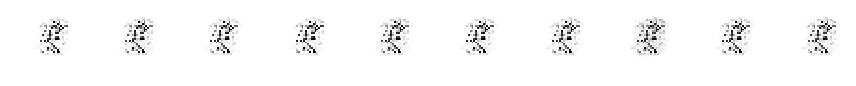

--------------- Epoch 20 ---------------


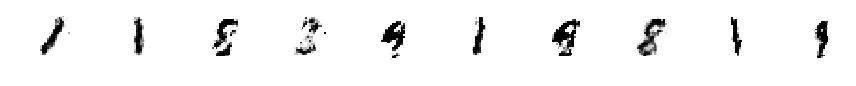

--------------- Epoch 40 ---------------


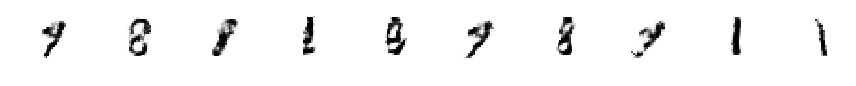

--------------- Epoch 60 ---------------


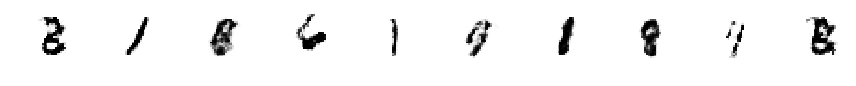

--------------- Epoch 80 ---------------


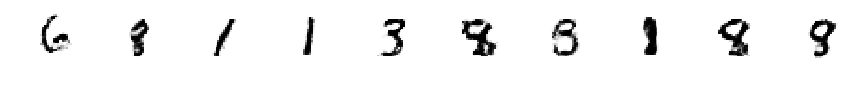

--------------- Epoch 100 ---------------


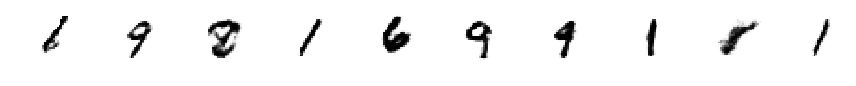

--------------- Epoch 120 ---------------


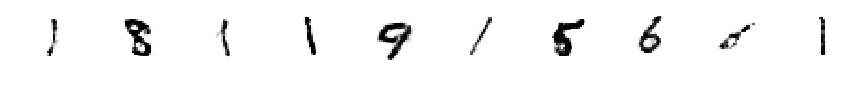

--------------- Epoch 140 ---------------


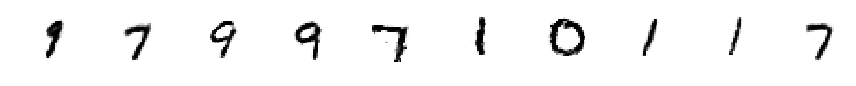

--------------- Epoch 160 ---------------


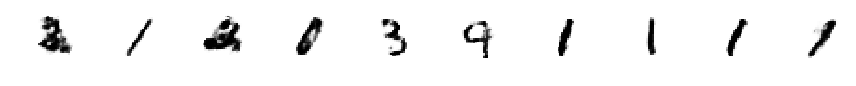

--------------- Epoch 180 ---------------


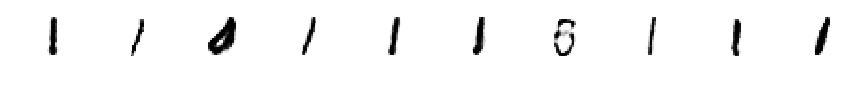

--------------- Epoch 200 ---------------


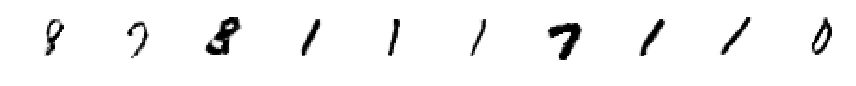

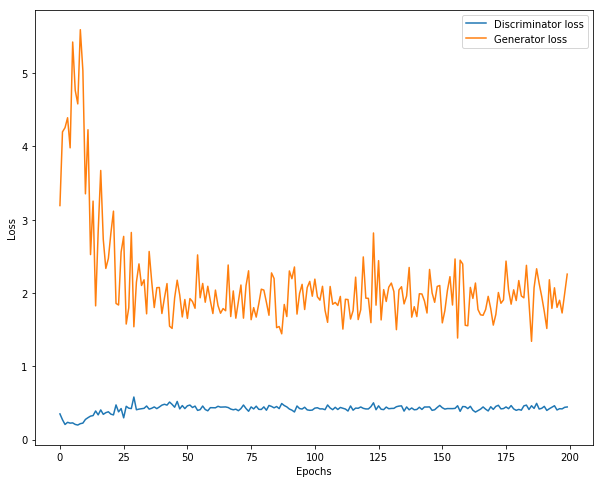

In [5]:
train(epochs=200, plt_frq=20, BATCH_SIZE=128)